# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

#### Импортируем необходимые для работы библиотеки

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Откроем и изучим файл с данными 

In [36]:
estate_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
estate_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Описание данных: 
- *airports_nearest* — расстояние до ближайшего аэропорта в метрах (м)
- *balcony* — число балконов
- *ceiling_height* — высота потолков (м)
- *cityCenters_nearest* — расстояние до центра города (м)
- *days_exposition* — сколько дней было размещено объявление (от публикации до снятия)
- *first_day_exposition* — дата публикации
- *floor* — этаж
- *floors_total* — всего этажей в доме
- *is_apartment* — апартаменты (булев тип)
- *kitchen_area* — площадь кухни в квадратных метрах (м²)
- *last_price* — цена на момент снятия с публикации
- *living_area* — жилая площадь в квадратных метрах(м²)
- *locality_name* — название населённого пункта
- *open_plan* — свободная планировка (булев тип)
- *parks_around3000* — число парков в радиусе 3 км
- *parks_nearest* — расстояние до ближайшего парка (м)
- *ponds_around3000* — число водоёмов в радиусе 3 км
- *ponds_nearest* — расстояние до ближайшего водоёма (м)
- *rooms* — число комнат
- *studio* — квартира-студия (булев тип)
- *total_area* — площадь квартиры в квадратных метрах (м²)
- *total_images* — число фотографий квартиры в объявлении

#### Посмотрим какие столбцы содержат пропущенные данные

In [37]:
columns_missed_data = estate_data.columns[estate_data.isna().any()].tolist()
columns_missed_data

['ceiling_height',
 'floors_total',
 'living_area',
 'is_apartment',
 'kitchen_area',
 'balcony',
 'locality_name',
 'airports_nearest',
 'cityCenters_nearest',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest',
 'days_exposition']

#### Возможные причины пропусков в данных:
- ceiling_height, living_area, kitchen_area, airports_nearest, cityCenters_nearest, parks_around3000, ponds_nearest, ponds_around3000 - хозяин квартиры мог просто не знать всю эту информацию, потому что эти данные достаточно специфичные и поэтому оставил их незаполненными
- airports_nearest, parks_around3000, ponds_nearest, ponds_around3000 - еще одной причиной пропусков этих данных может быть отсутствие аеропортов, парков, водоемов в данном населенном пункте
- is_apartment - скорее всего эта информаци пропущена для тех квартир, которые не являются апартаментами
- balcony - отсутстие информации о количестве балконов может свидетельствовать об их отсутствии
- days_exposition - отсутствие данной информации может говорить о том, что квартира еще не продана.

In [38]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Исследовал первые элементы таблицы объявлений о продаже квартир. Продумал возможные причины появления пропусков в данных. Исследовал типы данных столбцов таблицы и обнаружил, что часть из них являются не тем типом, который мы ожидали.

### Шаг 2. Предобработка данных

#### Заменим название столбца cityCenters_nearest на более каноничное city_centers_nearest

In [39]:
estate_data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)
'city_centers_nearest' in estate_data.columns.tolist()

True

#### Проверим таблицу на дубликаты

In [40]:
estate_data.duplicated().sum()

0

#### Восстановим пропущенные данные в столбцах kitchen_area и living_area, исходя из общей площади квартиры. Для этого сначало посчитаем среднее отношение площади кухни и жилой площади к общей площади. Затем для пропущенных значений kitchen_area  и living_area высчитаем их значение в зависимости от total_area.

In [41]:
kitchen_to_total = (estate_data['kitchen_area'] / estate_data['total_area']).median()
living_to_total = (estate_data['living_area'] / estate_data['total_area']).median()

def fill_area(coefficient, column):
    
    def inner_fill(row):
        area_to_fill = row[column]
        total_area = row['total_area']
        if np.isnan(area_to_fill):
            return total_area * coefficient
        return area_to_fill
    
    return inner_fill

In [42]:
estate_data['kitchen_area'] = estate_data.apply(fill_area(kitchen_to_total, 'kitchen_area'), axis = 1)
estate_data['living_area'] = estate_data.apply(fill_area(living_to_total, 'living_area'), axis = 1)

#### Заполним пропущенные данные в столбце balcony на 0, так как логично предположить, что если информация о количестве балконов пропущена, то балконов просто нет в квартире.

In [43]:
estate_data['balcony'] = estate_data['balcony'].fillna(0)
estate_data['balcony'].isna().sum()

0

#### Заполним пропущенные данные в стоблце is_apartment на False, так как скорее всего если эта информация пропущена, то это не apartment.

In [44]:
estate_data['is_apartment'] = estate_data['is_apartment'].fillna(False)
estate_data['is_apartment'].isna().sum()

0

 ponds_around3000

#### Заполним пропущенные данные в столбцах parks_around3000, ponds_around3000 на 0, так как причиной пропусков этих данных может быть отсутствие аеропортов, парков, водоемов в данном населенном пункте

In [45]:
estate_data['parks_around3000'] = estate_data['parks_around3000'].fillna(0)
estate_data['ponds_around3000'] = estate_data['ponds_around3000'].fillna(0)
estate_data[['ponds_around3000', 'parks_around3000']].isna().sum().sum()

0

#### Заменим тип данных столбца is_apartment с object на bool. 

In [46]:
estate_data['is_apartment'] = estate_data['is_apartment'].astype('bool', errors='ignore')
estate_data['is_apartment'].dtype

dtype('bool')

#### Заменим тип данных столбца first_day_exposition с object на datetime. 

In [47]:
estate_data['first_day_exposition'] = pd.to_datetime(estate_data['first_day_exposition'])
estate_data['first_day_exposition'].dtype

dtype('<M8[ns]')

### Шаг 3. Посчитайте и добавьте в таблицу

#### Добавим столбец стоимости квадратного метра, разделив last_price на total_area

In [48]:
estate_data['price_per_square'] = estate_data['last_price'] / estate_data['total_area']
estate_data['price_per_square'].head()

0    120370.370370
1     82920.792079
2     92785.714286
3    408176.100629
4    100000.000000
Name: price_per_square, dtype: float64

#### Извлечем day, month, year со столбца first_day_exposition

In [49]:
estate_data['day'] = estate_data['first_day_exposition'].dt.day
estate_data['month'] = estate_data['first_day_exposition'].dt.month
estate_data['year'] = estate_data['first_day_exposition'].dt.month
estate_data[['day', 'month', 'year']].head()

,day,month,year
0,7,3,3
1,4,12,12
2,20,8,8
3,24,7,7
4,19,6,6


#### Добавим столбец floor_name, применив к датафрэйму метод floor_name

In [50]:
def floor_name(row):
    floor_names = {1: 'первый', row['floors_total']: 'последний'}
    return floor_names.get(row['floor']) or 'другой'

estate_data['floor_name'] = estate_data.apply(floor_name, axis=1)
estate_data['floor_name'].head()

0    другой
1    первый
2    другой
3    другой
4    другой
Name: floor_name, dtype: object

#### Вычислим соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [51]:
estate_data['living_ratio'] = estate_data['living_area'] / estate_data['total_area']
estate_data['kitchen_ratio'] = estate_data['kitchen_area'] / estate_data['total_area']
estate_data[['living_ratio', 'kitchen_ratio']].head()

,living_ratio,kitchen_ratio
0,0.472222,0.231481
1,0.460396,0.272277
2,0.612500,0.148214
3,0.567860,0.172414
4,0.320000,0.410000


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Построим гистограммы для столбцов total_area, last_price, rooms, ceiling_height

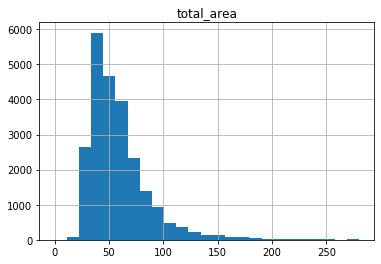

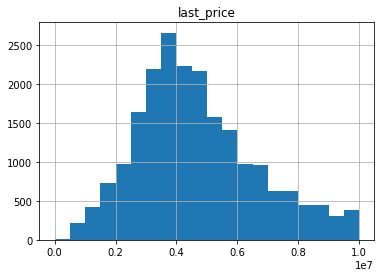

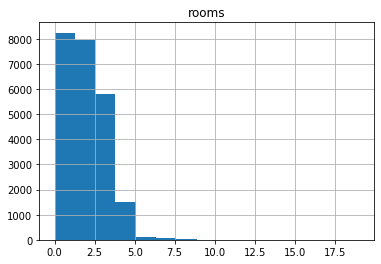

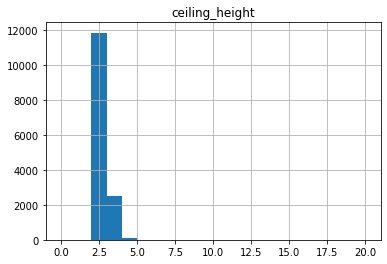

In [52]:
create_params = lambda bins, range: {"bins": bins, "range": range }

hist_params = [
                create_params(25,(0,280)), 
                create_params(20,(0,10000000)), 
                create_params(15,(0,19)), 
                create_params(20,(0,20))
]

columns = ['total_area', 'last_price', 'rooms', 'ceiling_height']

for i in range(len(columns)):
    params = hist_params[i]
    plt.figure()
    plt.title(columns[i])
    estate_data[columns[i]].hist(bins=params.get('bins'), range=params.get('range'))

Из гистограммы total_area видно, что больше всего квартир имеют площадь 35-40 квадратных метров. Квартиры с количеством квадратных метров более 150 или менее 20 встречаются редко.

Из гистограммы last_price видно, что больше всего квартир имеют стоимость между 3000000 и 4000000. Стоимость меньшая 1000000 считается низкой и встречается крайне редко. Стоимость большая 9000000 считается высокой и также встречается редко.

Из гистограммы rooms видно, что больше всего квартир имеют 1 или 2 комнаты. Также присутствуют значения меньше 1 которые являются аномалиями, которые необходимо будет удалить. Значения больше 5 встречаются крайне редко.

Из гистограммы ceiling_height видно, что больше всего квартир имеют высоту потолков от 2 до 3 метров. Пололки высотой свыше 3.5 метров встречаются редко

#### Изучим время продажи квартиры.

#### Посмотрим на медианное время продажи квартиры

In [53]:
estate_data['days_exposition'].median()

95.0

#### Посмотрим на среднее время продажи квартиры

In [54]:
estate_data['days_exposition'].mean()

180.88863436982163

#### Построим гистограмму времени продажи квартиры

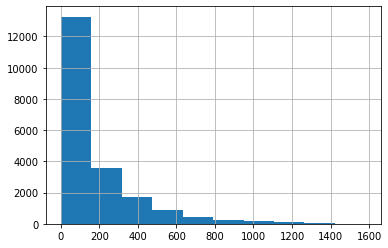

In [55]:
estate_data['days_exposition'].hist()

#### Посмотрим на значения метрик времени продажи 

In [56]:
estate_data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Из гистограммы видно, что обычно продажа занимает менее 180 дней. Длинным временем продажи можно считать значения более 800 дней. Очень быстрым временем продажи можно считать значения меньшие 20 дней.

#### Уберем редкие и выбивающиеся значения

#### Построим диаграмму размаха для колонок days_exposition, ceiling_height, rooms, rooms, last_price, total_area

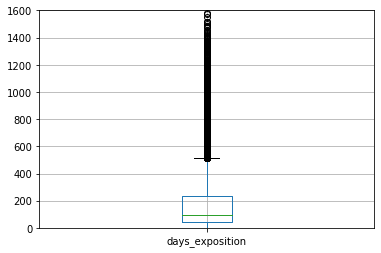

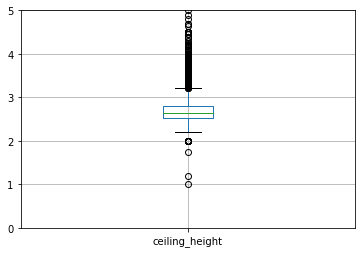

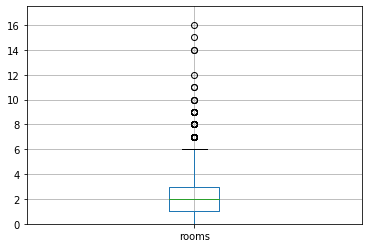

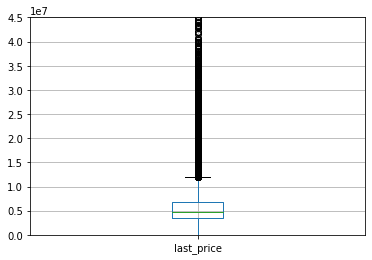

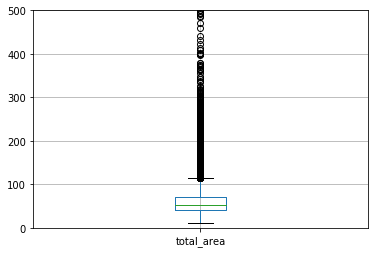

In [57]:
    columns = ['days_exposition', 'ceiling_height', 'rooms', 'last_price', 'total_area']
    ylimits = [1600, 5, 17.5, 4.5*10**7,  500]
    for i in range(len(columns)):
        plt.figure()
        plt.ylim(0, ylimits[i])
        estate_data.boxplot(column=columns[i])

#### Удалим выбросы на основе диаграмм размаха.

Значения больше 500 для days_exposition являются выбросами.

In [61]:
estate_data = estate_data.query('days_exposition < 500')

Потолки высотой меньше 2 метров и больше 3.5 являются выбросами.

In [62]:
estate_data = estate_data.query('ceiling_height > 2 and ceiling_height < 3.5')

Значения больше 6 для rooms являются выбросами.

In [63]:
estate_data = estate_data.query('rooms <= 6')

Цины выше 12000000 являются выбросами.

In [64]:
estate_data = estate_data.query('last_price < 12000000')

Значения больше 120 для days_exposition являются выбросами.

In [65]:
estate_data = estate_data.query('total_area < 120')

#### Выясним, какие факторы больше всего влияют на стоимость квартиры.

#### Выделим факторы для оценки

In [66]:
factors = ['total_area', 'rooms', 'floor', 'city_centers_nearest', 'day', 'month', 'year']

#### Для каждого из факторов построим диаграмму рассеивания а также посмотрим на коэффициент корреляции пирсона

corr total_area 0.7078694057398367
corr rooms 0.45065700705132855
corr floor 0.15727626372812362
corr city_centers_nearest -0.33328543690066936
corr day -0.004275057685467179
corr month 0.009320299165078793
corr year 0.009320299165078793


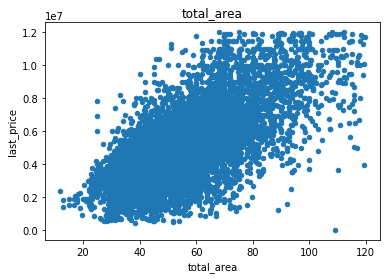

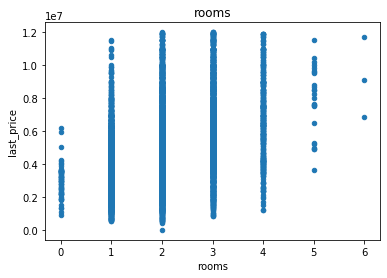

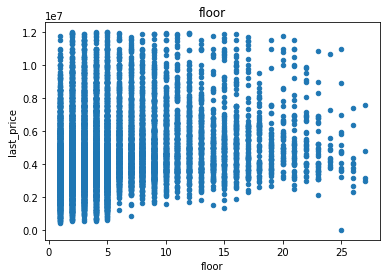

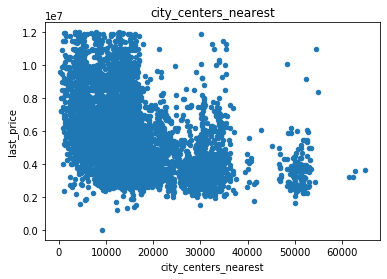

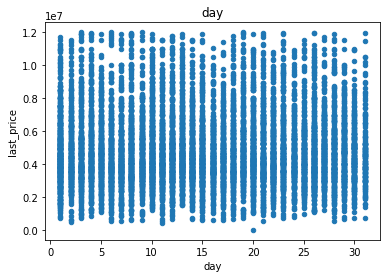

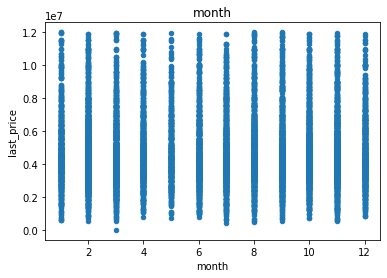

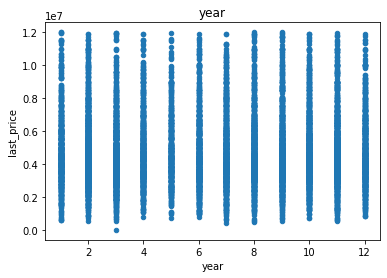

In [67]:
for factor in factors:
    corr = estate_data['last_price'].corr(estate_data[factor])
    estate_data.plot(x=factor, y='last_price', kind='scatter', title=factor)
    print('corr', factor, corr)

#### Посмотрим на зависимость цены и площади квартиры

Из диаграммы рассеивания видно, что точки между 40 и 100 квадратными метрами расположены очень плотно друг к другу, а также график возрастает на этом участке. Исходя из коэффициента пирсона и диаграммы рассеивания можно сделать вывод, что существует прямая зависимость между площадью квартиры и ее стоимостью. Также на графике видны опреденные явно "выбивающиеся" значения на участке от 110 квадратных метров.

#### Посмотрим на зависимость цены и количества комнат

Из диаграммы рассеивания видно, что квартиры с одинаковым количеством комнат могут иметь совершенно разные цены. Невозможно выделить убывание или возростание цены в зависимости от количества комнат, однако коэффициент пирсона равный 0.45 свидетельствует об определенной зависимости между данными параметрами. Исходя из этого можно сделать вывод, что количество комнат влияет на стоимость квартиры, хоть и не так сильно как total_area.

#### Посмотрим на зависимость цены и этажа

Из диаграммы рассеивания видно, что квартиры расположенные на одном и том же этаже могут иметь совершенно разные цены. Из особенностей можно выделить, что квартиры расположенные выше 15 этажа имеют стартовую цену выше квартир расположенных ниже. Все это а также низкий
коэффициент пирсона 0.26 свидетельствуют об отсутствии явной зависимости между ценой квартиры и этажа, на котором расположена квартира.

#### Посмотрим на зависимость цены от удаленности квартиры от центра

Из диаграммы рассеивания видно, что при отдалении квартир от центра их стоимость снижается, так как график убывает и коэффициент пирсона -0.33 отрицательный. Также квартиры расположенные относительно близко к центру могут иметь совершенно разные цены, что свидетельствует о том, что это не ключевой показатель в стоимости квартиры, несмотря на определенную зависимость.

#### Посмотрим на зависимость цены от месяца, дня недели, года создания объявления

Из всех 3 диагррам рассеивания видно, что данные расположены совершенно хаотично. Также коэффициенты пирсона < 0.1. Из всего этого делаем вывод, что цена квартиры не зависит от того, когда появилось объявление.

### Вывод

Среди перечисленных выше факторов, наиболее важным при установлении цены является общая площать квартиры. Также определенный вклад в эту стоимость вносит расстояние квартиры до центра. А вот такие факторы как этаж квартиры и дата добавлени объявления практически не влияют на цену.

### Найдем населенные пункты с самой высокой и самой низкой стоимостью жиль, среди населенных пунктов с наибольшим числом объявлений.

#### Найдем топ 10 населенных пунктов по количеству объявлений

In [68]:
top_localitis = (estate_data.groupby('locality_name')['locality_name']
             .count()
             .sort_values(ascending=False)
             .head(10)
             .index
             .tolist()
)
top_localitis

['Санкт-Петербург',
 'Всеволожск',
 'посёлок Шушары',
 'посёлок Мурино',
 'Колпино',
 'Пушкин',
 'посёлок Парголово',
 'Гатчина',
 'Петергоф',
 'деревня Кудрово']

#### Посчитаем среднюю цену квадратного метра в этих населенных пунктах

In [69]:
median_prices = pd.DataFrame(columns=['locality_name', 'median_price_per_square'])
for locality in top_localitis:
    median_price = estate_data.query('locality_name == @locality')['price_per_square'].median()
    median_prices = median_prices.append({'locality_name': locality, 'median_price_per_square': median_price}, ignore_index=True)
median_prices.head()

,locality_name,median_price_per_square
0,Санкт-Петербург,101562.500000
1,Всеволожск,64875.820960
2,посёлок Шушары,77355.715871
3,посёлок Мурино,87006.997455
4,Колпино,72915.036940


#### Построим график стоимости среднего квадратного метра для этих городов

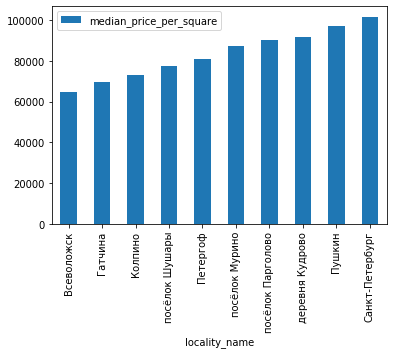

In [70]:
(median_prices
         .sort_values(by='median_price_per_square')
         .plot(x='locality_name', y='median_price_per_square', kind='bar')
)

### Вывод

Среди 10 населенных пунктов с наибольшим числом объявлений, самый дешевый квадратный метр в Выборге, а самый дорогой в Санкт-Петербурге.

### Выясним какая область входит в центр Санкт-Петербурга

#### Получим квартиры расположенные в  Санкт-Петербурге и удалим квартиры неимеющие данные об удаленности от центра

In [71]:
piter_estate_data = estate_data.query('locality_name == "Санкт-Петербург"')
piter_estate_data = piter_estate_data.dropna(subset=['city_centers_nearest'])

#### Создадим столбец удаленности квартиры от центра в километрах

In [72]:
piter_estate_data['city_centers_nearest_km'] = piter_estate_data['city_centers_nearest'].apply(lambda dist: round(dist / 1000))
piter_estate_data = piter_estate_data.query('city_centers_nearest_km > 0')

#### Создадим сводную таблицу средней стоимости квадратного метра для одинаково удаленных от центра квартир

In [73]:
mean_city_centers_price = piter_estate_data.pivot_table(index='city_centers_nearest_km', values='price_per_square')
mean_city_centers_price.head()

,price_per_square
city_centers_nearest_km,
1,121293.820375
2,117679.822826
3,106419.082672
4,115713.658684
5,121752.325990


#### Построим графики для полученной таблицы

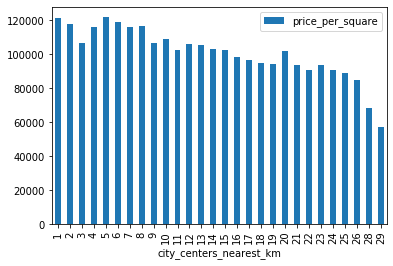

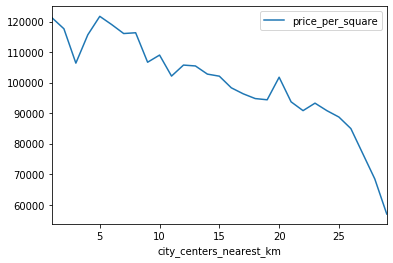

In [74]:
mean_city_centers_price.plot(kind='bar')
mean_city_centers_price.plot()

### Вывод

Из графиков видно, что после 8 километров начинается более менее равномерный спад стоимости жилья, следовательно квартиры расположенные не дальше 8 километров центра находятся в центральной области.

###  Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

#### Выделим сегмент квартир в центре

In [75]:
piter_estate_data = piter_estate_data.query('city_centers_nearest_km < 9')

#### Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков, удаленность от центра,  дата размещения объявления  

corr total_area 0.7156221509649314
corr rooms 0.4802183086700507
corr floor 0.15661762437541132
corr city_centers_nearest_km -0.18981584320019168
corr day -0.00829001600425228
corr month 0.0010962403502330225
corr year 0.0010962403502330225


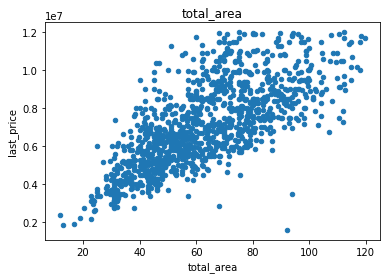

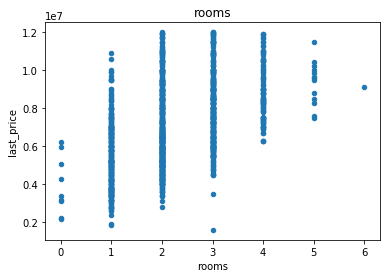

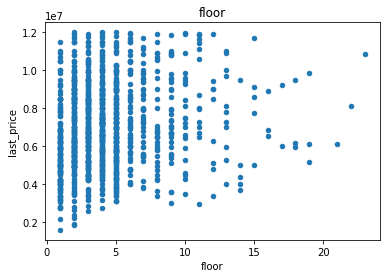

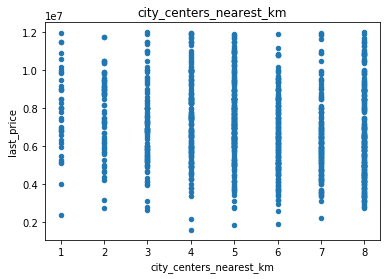

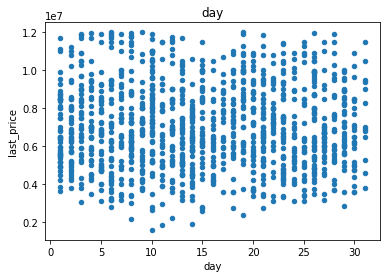

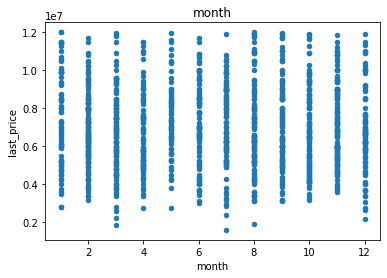

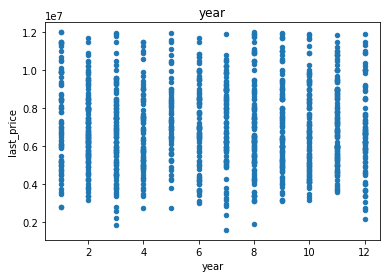

In [76]:
factors = ['total_area', 'rooms', 'floor', 'city_centers_nearest_km', 'day', 'month', 'year']
for factor in factors:
    corr = piter_estate_data['last_price'].corr(piter_estate_data[factor])
    piter_estate_data.plot(x=factor, y='last_price', kind='scatter', title=factor)
    print('corr', factor, corr)

### Вывод

Исходя из графиков и коэффициентов корреляции можно сказать, что по прежнему дата размещения объявления не влияет на стоимость квартиры. Общая площадь квартиры больше всего коррелирует со стоимостью жилья. Уменьшилась корреляция между ценой и удаленностью от центра, что связано с тем, что в нашей текущей выборке все квартиры являются центральными. Остальные параметры практически не изменились.

### Шаг 5. Общий вывод

Исследовав объявления о продаже квартир установили параметры, которые оказывают наибольшее влияние на стоимость квартиры, а именно: общая площадь квартиры, количество комнат, удаленность от центра. Выяснили какие параметры практически не оказывают влияния на стоимость квартиры, а именно: дата публикации, этаж на котором находится квартира. Также исследовали квартиры находящиеся в центральной области Санкт-Петербурга. Сравнили общие показатели с показателями Санкт-Петербурга, которые оказались очень схожими с общими показателями. Выяснили в каких городах в среднем самое дорогое и дешевое жилье среди городов с наибольшим числом объявлений. Ими оказались Всеволожск и Санкт-Петербург соответственно. Все эти показатели помогут построить автоматизированную систему, которая сможет отслеживать аномалии и мошенническую деятельность.